NIM: 2440021451

Nama: Oei Angela Christabel Gunawan

#Implement SIFT from scratch

In [175]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32, float64
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST, imread
from functools import cmp_to_key
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

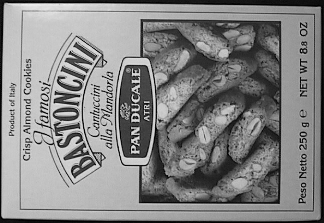

In [176]:
image = imread('box.png', 0)
image = image.astype(float64)
cv2_imshow(image)

The SIFT algorithm can be divided into 6 steps:
1. Constructing a scale space
2. LoG Approximation
3. Finding keypoints
4. Assigning orientation
5. Eliminate bad keypoints
6. Generate descriptors

##1. Construct scale space

In this step we will construct internal copies/representations of the image with different scales and and blurring degrees to ensure scale invariance. This collection of images is also called a "scale space".

![link text](https://miro.medium.com/max/1100/1*cJF_YgCOMjhZDJQinfojTA.png)

![link text](https://miro.medium.com/max/1100/1*FgIvcdMirRCZr80IxDjEVg.png)

Function untuk melakukan blur dan membesarkan image asli kita.

In [177]:
def generate_base_image(image, sigma, assumed_blur):
  # Kita coba upsample x2 dalam arah x dan y
  image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
  sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
  return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

In [178]:
def get_num_octaves(image_shape):
  '''
  Function untuk menghitung jumlah oktaf dalam image pyramid kita. Angka yang dihasilkan 
  adalah jumlah kali kita bisa membelah image kita sampai sizenya terlalu kecil. Misalnya y 
  adalah sisi terpendek dan minimal panjang sisi image adalah 1 pixel, maka kita bisa mendapatkan 
  rumus y/2^x = 1 dan kita bisa solve x (jml membelah image) dengan log(y)/log(2).
  '''
  return int(round(log(min(image_shape)) / log(2) - 1))

In [179]:
def generate_gaussian_kernels(sigma, num_intervals):
  '''
  Function selanjutnya menghitung seberapa banyak blur yang harus diaplikasikan pada image 
  dalam setiap layer. Dalam satu scale-space pyramid, kita memiliki beberapa octave, 
  setiap octave terdiri dari layer image dengan size yang sama tetapi tingkat blur yang berbeda. 
  How much we blur setiap image itu akan kita hitung dalam function ini.
  '''
  num_images_per_octave = num_intervals + 3
  k = 2 ** (1. / num_intervals)
  gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
  gaussian_kernels[0] = sigma

  for image_index in range(1, num_images_per_octave):
      sigma_previous = (k ** (image_index - 1)) * sigma
      sigma_total = k * sigma_previous
      gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
  return gaussian_kernels

In [180]:
def generate_scale_space(image, num_octaves, gaussian_kernels):
    gaussian_images = []

    for octave_index in range(num_octaves):
        # Dalam setiap octave kita memiliki bbrp gambar dgn size/scale yg sama, blur yg beda
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        # Kita ambil image layer tengah dalam setiap octave dan menjadikannya basis untuk octave selanjutnya (scale selanjutnya)
        octave_base = gaussian_images_in_octave[-3]
        # Image octave_base ini kita masukkan dalam function resize untuk dikecilkan (dibagi 2)
        # Jadi octave selanjutnya memiliki scale 1/2 dari octave sebelumnya
        # Sesuai dengan ilustrasi pyramid di atas, 3 octave tsb memiliki scale 2^n+1, selanjutnya 2^n, lalu 2^n-1
        # Setiap octave diatas memiliki scale 1/2 dari octave di bawahnya
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images)

##2. LoG approximation

Melakukan LoG operation on an image berarti kita harus mencari sum dari second-order derivative atau "Laplacian" dari image tersebut. Ini berguna untuk mendapatkan edge dan corner pada image. Supaya LoG bersifat scale-invariant maka bisa dikalikan dengan sigma^2.

Tetapi untuk SIFT untuk mempercepat perhitungan, kita akan mengaproksimasi persamaan LoG pada image-image kita dengan menghitung Difference of Gaussian (DoG).

Relasi antar DoG dan sigma^2 * LoG dapat dilihat pada rumus berikut:

![link](https://miro.medium.com/max/720/1*cAm1d-OIO1Xw1zDgk5WJCA.png)

sehingga:

![link](https://miro.medium.com/max/720/1*DrY9v9tD2KOs6drO6B1E3w.png)

dengan (k-1) sebagai konstanta untuk semua scales.

Oleh karena itu, kita butuh mengenerate Difference of Gaussian images kita. Disini kita menggunakan gaussian kernels yang didapatkan pada step sebelumnya.

In [181]:
def generate_dog_images(gaussian_images):
  dog_images = []

  for gaussian_images_in_octave in gaussian_images:
      dog_images_in_octave = []
      for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
          # ordinary subtraction will not work because the images are unsigned integers
          dog_images_in_octave.append(subtract(second_image, first_image))  
      dog_images.append(dog_images_in_octave)
  return array(dog_images)

Disini kita coba intip oktaf ketiga dari scale space kita, dan bandingkan dengan oktaf ketiga dari piramida DoG images kita. Ingat bahwa:


```
dog_images[2][i] = gaussian_images[2][i + 1] — gaussian_images[2][i]
```



In [182]:
sigma = 1.6
n_intervals = 3
assumed_blur = 0.5

img_base = generate_base_image(image, sigma, assumed_blur)
n_octaves = get_num_octaves(img_base.shape)
gaussian_kernels = generate_gaussian_kernels(sigma, n_intervals)
scale_space = generate_scale_space(img_base, n_octaves, gaussian_kernels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


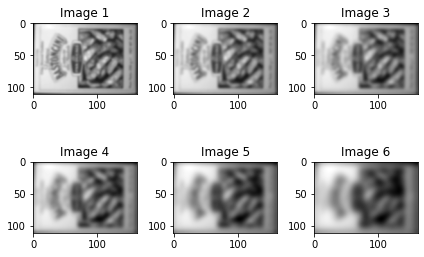

In [183]:
for i, image in zip(range(1, len(scale_space[2])+1), scale_space[2]):
  plt.subplot(2, 3, i)
  plt.title(f'Image {i}')
  plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

In [184]:
dog_images = generate_dog_images(scale_space)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


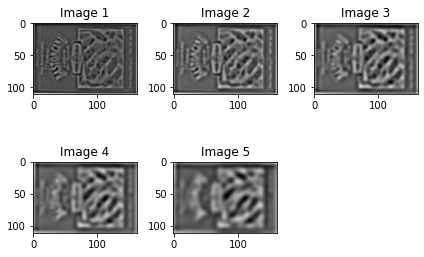

In [185]:
for i, image in zip(range(1, len(dog_images[2])+1), dog_images[2]):
  plt.subplot(2, 3, i)
  plt.title(f'Image {i}')
  plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

##3. Finding keypoints

Setelah mendapatkan Difference of Gaussian images kita, saatnya mencari keypoints dalam piramida kita.

Untuk mencari keypoints yang dibutuhkan kita membutuhkan beberapa function bantuan di bawah ini:

In [186]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  '''
  Untuk mencari scale space extrema, kita akan melakukan iterasi melalui setiap layer, mengambil 
  3 images di tiap iterasi. Dari ketiga images tersebut, function `isPixelAnExtremum()`
  ini akan mencari pixel yang, jika dibandingkan dengan pixel tetangganya (26, 8 pixel dari middle 
  image, 9 pixel dari image di bawah dan 9 pixel lainnya dari image di atasnya) merupakan pixel 
  yang extremum (maximam atau minimum).
  '''
  center_pixel_value = second_subimage[1, 1]
  if abs(center_pixel_value) > threshold:
      if center_pixel_value > 0:
          return all(center_pixel_value >= first_subimage) and \
                  all(center_pixel_value >= third_subimage) and \
                  all(center_pixel_value >= second_subimage[0, :]) and \
                  all(center_pixel_value >= second_subimage[2, :]) and \
                  center_pixel_value >= second_subimage[1, 0] and \
                  center_pixel_value >= second_subimage[1, 2]
      elif center_pixel_value < 0:
          return all(center_pixel_value <= first_subimage) and \
                  all(center_pixel_value <= third_subimage) and \
                  all(center_pixel_value <= second_subimage[0, :]) and \
                  all(center_pixel_value <= second_subimage[2, :]) and \
                  center_pixel_value <= second_subimage[1, 0] and \
                  center_pixel_value <= second_subimage[1, 2]
  return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        # logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        # logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

Setelah kita mendapatkan pixel yang merupakan extremum, kita akan melokalisasi posisinya pada subpixel level pada 3 dimensi (width, height, dan scale) menggunakan function di bawah ini. Untuk melokalisasi sebuah keypoint, kita menggunakan prosedur yang dijelaskan dalam SIFT paper. Intinya, kita akan fit sebuah quadratic model terhadap keypoint pixel serta 26 pixel tetangganya tadi (dalam variabel `pixel_cube`). Kita biarkan model menjalankan iterasi sampai converge ke satu lokasi pixel.

Pada function ini juga, kita akan mengecek apakah keypoint pixel yang dipilih setelah lokalisasi memiliki kontras yang cukup.

Secara garis besar, rasio dari eigenvalues dari 2D Hessian pada lebar dan tinggi sebuah keypoint image memberikan informasi tentang kontrasnya. Oleh karena itu, kita akan menggunakan 2 helper function yaitu `computeGradientAtCenterPixel()` dan `computeHessianAtCenterPixel()`
yang berfungsi untuk mengimplementasi second-order central finite difference approximations dari gradien dan hessian dalam 3 dimensi untuk menghasilkan estimasi extrema yang lebih akurat.

##4. Assigning orientation

Sekarang kita perlu mencatat orientasi dari keypoint kita. Function di bawah ini akan melakukan itu.

Algoritma yang dipakai disini adalah, untuk menentukan orientation dari keypoint, kita akan membuat sebuah histogram dari gradien pixel-pixel yang ada di sekitar keypoint tersebut. Kita mengambil pixel-pixel yang berada dalam jarak `radius_factor * scale` dari keypoint. Jadi, kita hanya akan melihat pixel yang berada dalam window tersebut.

Selanjutnya, kita akan menghitung magnitude dan orientasi dari gradien tiap pixel dalam window tersebut dan membuatkan sebuah histogram terdiri dari 36 bin (10 derajat tiap bin).

Lalu, kita melakukan smoothing terhadap histogram tersebut, dan mencari peak dari histogram yang sesuai threshold yang dijelaskan dalam paper SIFT. Kita membuat keypoint yang berbeda sesuai besar derajat peak yang ditemukan.

In [187]:
float_tolerance = 1e-7

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

Function di bawah ini menggabungkan semua function di atasnya untuk mencari extrema dan orientationnya dari scale space kita.

In [188]:
def find_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
  threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
  keypoints = []

  for octave_index, dog_images_in_octave in enumerate(dog_images):
      for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
          # (i, j) is the center of the 3x3 array
          for i in range(image_border_width, first_image.shape[0] - image_border_width):
              for j in range(image_border_width, first_image.shape[1] - image_border_width):
                  if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                      localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                      if localization_result is not None:
                          keypoint, localized_image_index = localization_result
                          keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                          for keypoint_with_orientation in keypoints_with_orientations:
                              keypoints.append(keypoint_with_orientation)
  return keypoints

##5. Eliminate bad keypoints

Function-function di bawah ini berfungsi untuk membersihkan keypoint yang sudah kita temukan di step sebelumnya.

In [189]:
# Function untuk membandingkan keypoints, akan return True jika
# keypoint 1 < keypoint 2
def compare_keypoints(keypoint1, keypoint2):
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

# Function ini mensortir keypoints dan membuang yang duplikat
def remove_duplicate_keypoints(keypoints):
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compare_keypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

# Function ini mengkonversi keypoint point, size, dan oktaf
# dari koordinat yang sesuai base_image (image yang sdh dibesarkan)
# ke koordinat yang sesuai image asli.
def convert_kp_to_image_size(keypoints):
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

##6. Generate descriptors

Selanjutnya, kita bisa men-generate descriptor yaitu sebuah vektor 128 dimensi yang dinormalisasi. Saat ini, kita memiliki keypoint yang memiliki informasi lokasi, scale, serta orientasi. Kita bisa menggunakan informasi tsb.

Untuk algoritmanya, kita akan membuat sebuah histogram untuk rotasi gradien lagi. Kita akan membuat sebuah window sekitar tiap keypoint, tapi windownya dirotate sesuai rotasi yang dicatat pada keypoint. Inilah mengapa SIFT dikatakan invariant terhadap rotation.

Selanjutnya, kita akan menghitung magnitude dan orientasi dari setiap pixel dan menyimpan data tersebut dalam bins, tapi sekarang kita gunakan 8 bin saja untuk 0-360 derajat.

Setelah itu, kita akan melakaukan trilinear interpolation untuk smoothing histogram-histogram tsb, flatten array yang kita dapatkan, dan kita akan mendapatkan sebuah vektor 128 dimensi sebagai descriptor setiap keypoint.

In [190]:
def unpack_octave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generate_descriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
  descriptors = []

  for keypoint in keypoints:
      octave, layer, scale = unpack_octave(keypoint)
      gaussian_image = gaussian_images[octave + 1, layer]
      num_rows, num_cols = gaussian_image.shape
      point = round(scale * array(keypoint.pt)).astype('int')
      bins_per_degree = num_bins / 360.
      angle = 360. - keypoint.angle
      cos_angle = cos(deg2rad(angle))
      sin_angle = sin(deg2rad(angle))
      weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
      row_bin_list = []
      col_bin_list = []
      magnitude_list = []
      orientation_bin_list = []
      histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

      # Descriptor window size (described by half_width) follows OpenCV convention
      hist_width = scale_multiplier * 0.5 * scale * keypoint.size
      half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
      half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

      for row in range(-half_width, half_width + 1):
          for col in range(-half_width, half_width + 1):
              row_rot = col * sin_angle + row * cos_angle
              col_rot = col * cos_angle - row * sin_angle
              row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
              col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
              if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                  window_row = int(round(point[1] + row))
                  window_col = int(round(point[0] + col))
                  if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                      dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                      dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                      gradient_magnitude = sqrt(dx * dx + dy * dy)
                      gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                      weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                      row_bin_list.append(row_bin)
                      col_bin_list.append(col_bin)
                      magnitude_list.append(weight * gradient_magnitude)
                      orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

      for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
          # Smoothing via trilinear interpolation
          # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
          # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
          row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
          row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
          if orientation_bin_floor < 0:
              orientation_bin_floor += num_bins
          if orientation_bin_floor >= num_bins:
              orientation_bin_floor -= num_bins

          c1 = magnitude * row_fraction
          c0 = magnitude * (1 - row_fraction)
          c11 = c1 * col_fraction
          c10 = c1 * (1 - col_fraction)
          c01 = c0 * col_fraction
          c00 = c0 * (1 - col_fraction)
          c111 = c11 * orientation_fraction
          c110 = c11 * (1 - orientation_fraction)
          c101 = c10 * orientation_fraction
          c100 = c10 * (1 - orientation_fraction)
          c011 = c01 * orientation_fraction
          c010 = c01 * (1 - orientation_fraction)
          c001 = c00 * orientation_fraction
          c000 = c00 * (1 - orientation_fraction)

          histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
          histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
          histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
          histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
          histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
          histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
          histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
          histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

      descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
      # Threshold and normalize descriptor_vector
      threshold = norm(descriptor_vector) * descriptor_max_value
      descriptor_vector[descriptor_vector > threshold] = threshold
      descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
      # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
      descriptor_vector = round(512 * descriptor_vector)
      descriptor_vector[descriptor_vector < 0] = 0
      descriptor_vector[descriptor_vector > 255] = 255
      descriptors.append(descriptor_vector)
  return array(descriptors, dtype='float32')

##Main Function

In [191]:
def sift_compute_keypoints_descriptors(image, sigma=1.6, n_intervals=3, assumed_blur=0.5, image_border_width=5):
  img_base = generate_base_image(image, sigma, assumed_blur)
  n_octaves = get_num_octaves(img_base.shape)
  gaussian_kernels = generate_gaussian_kernels(sigma, n_intervals)
  scale_space = generate_scale_space(img_base, n_octaves, gaussian_kernels)
  dog_images = generate_dog_images(scale_space)
  keypoints = find_scale_space_extrema(scale_space, dog_images, n_intervals, sigma, image_border_width)
  keypoints = remove_duplicate_keypoints(keypoints)
  keypoints = convert_kp_to_image_size(keypoints)
  descriptors = generate_descriptors(keypoints, scale_space)
  return keypoints, descriptors

#Matching using FLANN

Kita akan menjalankan function SIFT yang sudah kita buat dan melakukan feature matching dengan cv2.FLANN dan cv2.BF2Matcher.

In [192]:
MIN_MATCH_COUNT = 10

image = imread('box.png', 0)           # queryImage
scene = imread('box_in_scene.png', 0)  # trainImage

# Compute SIFT keypoints and descriptors
kp1, des1 = sift_compute_keypoints_descriptors(image)
kp2, des2 = sift_compute_keypoints_descriptors(scene)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykern

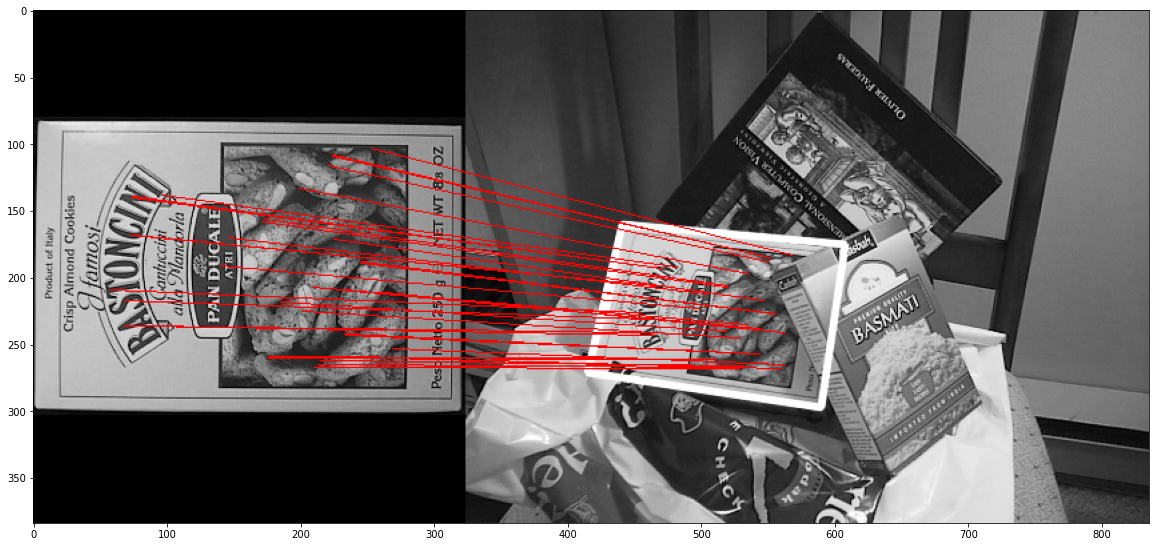

In [196]:
import numpy as np
import cv2

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = image.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(scene, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = image.shape
    h2, w2 = scene.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = image
        newimg[:h2, w1:w1 + w2, i] = scene

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))
    plt.figure(figsize=(20, 16))
    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

#Matching using BFMatcher

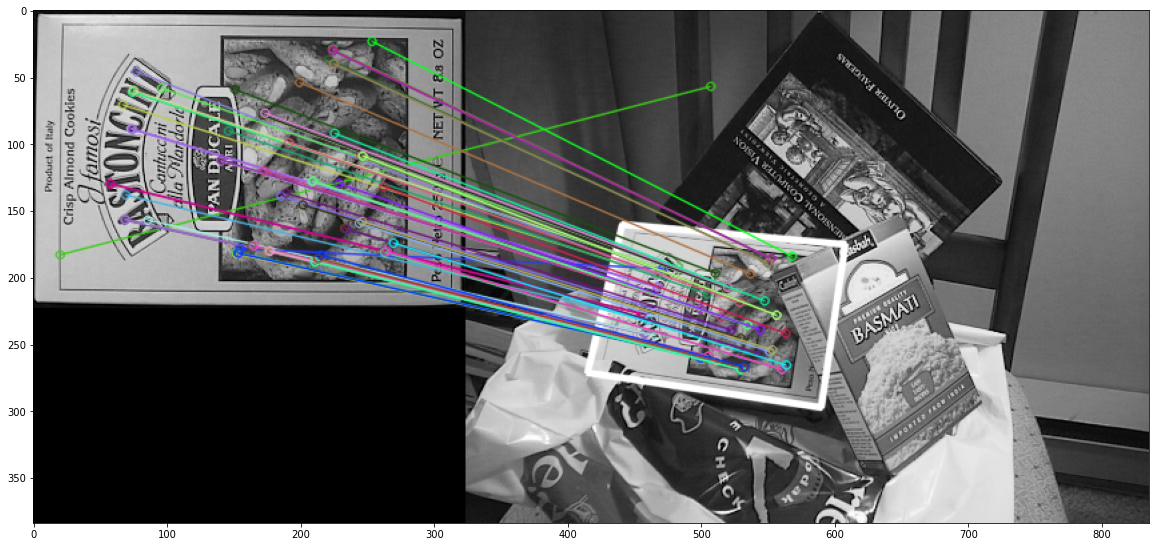

In [195]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(image, kp1, scene, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 16))
plt.imshow(img3)
plt.show()

Bisa kita lihat bahwa menggunakan FLANN Matcher lebih akurat, ada satu match yang seharusnya tidak relevan tapi dideteksi oleh BFMatcher, yaitu satu garis hijau dari box di kiri dengan kursi di kanan.